In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from corner import corner
import model_b2 as model
import emcee
from multiprocess import Pool
from scipy import stats
# import scienceplots
import datetime
# plt.style.use('science')

In [2]:
os.environ['OMP_NUM_THREADS'] = '1'

In [3]:
theta0 = model.azr.config.get_input_values()

In [4]:
capture_ground, capture_excited, capture_total = model.azr.predict(theta0, dress_up=False)

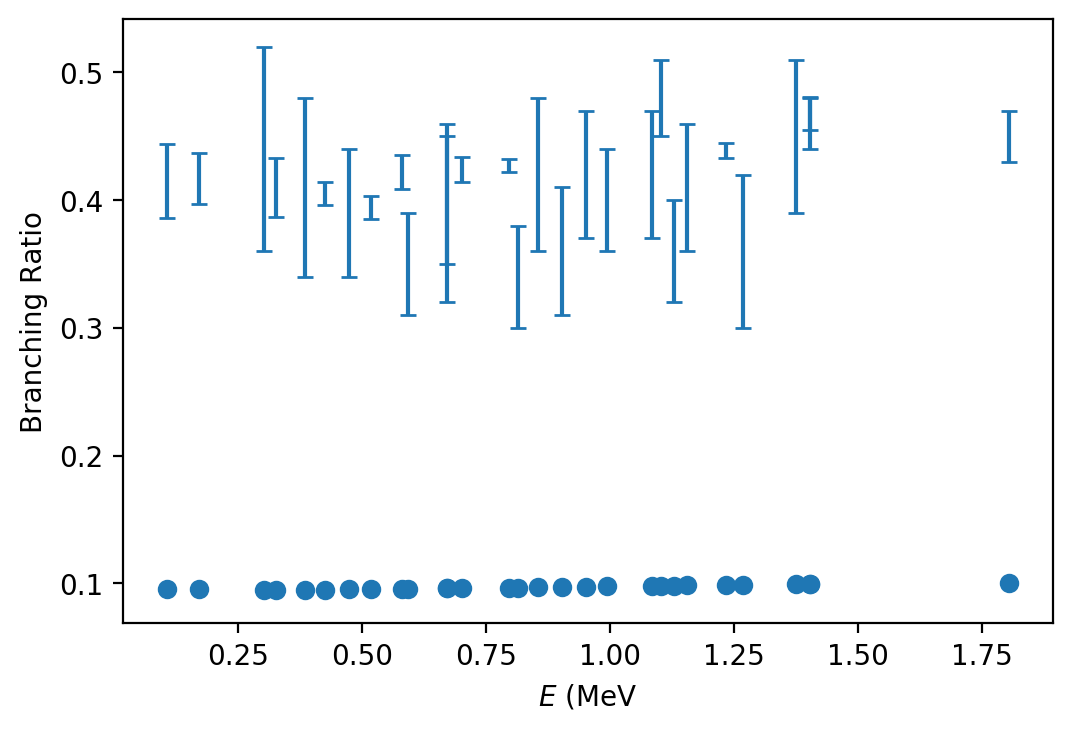

In [5]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.scatter(capture_excited[:, 0], capture_excited[:, 3] / capture_ground[:, 3])
ax.errorbar(capture_excited[:, 0], capture_excited[:, 5], yerr=capture_excited[:, 6], linestyle='', capsize=3)

ax.set_xlabel(r'$E$ (MeV')
ax.set_ylabel('Branching Ratio');

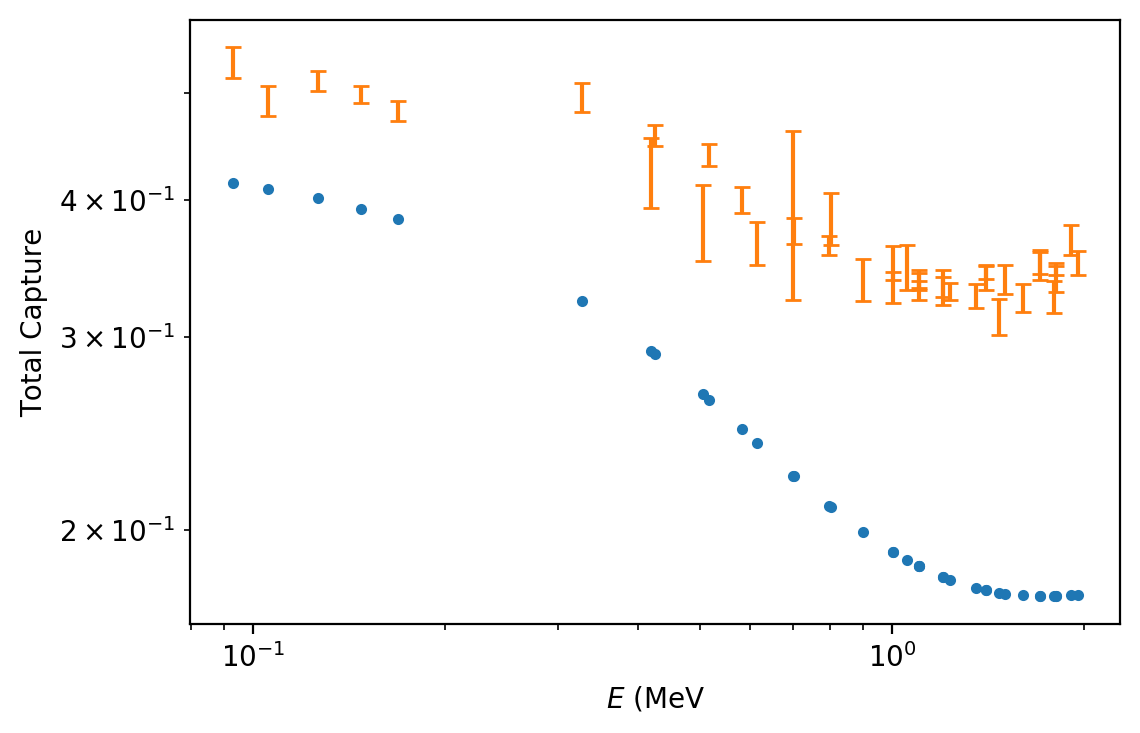

In [6]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot(capture_total[:, 0], 1000*capture_total[:, 4], linestyle='', marker='.')
ax.errorbar(capture_total[:, 0], 1000*capture_total[:, 7], yerr=1000*capture_total[:, 8], linestyle='', capsize=3)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$E$ (MeV')
ax.set_ylabel('Total Capture');

In [7]:
np.savetxt('bare_uncertainties_2.txt', np.vstack((capture_ground, capture_total))[:, 6])

In [8]:
model.ln_prior(theta0)

-122.90150801985155

In [9]:
model.ln_likelihood(theta0)

-27732.13233973232

In [10]:
nd = model.azr.config.n1 + model.azr.config.n2
nw = 2*nd

theta0 = model.azr.config.get_input_values()
p0 = np.array([[stats.norm(x, np.abs(x)/1000).rvs() for x in theta0] for _ in range(nw)])

In [11]:
backend = emcee.backends.HDFBackend('model_2.h5')
backend.reset(nw, nd)

In [ ]:
with Pool(16) as pool:
    sampler = emcee.EnsembleSampler(nw, nd, model.ln_posterior, pool=pool, backend=backend,
                                    moves=[(emcee.moves.DEMove(), 0.8), (emcee.moves.DESnookerMove(), 0.2)])
    state = sampler.run_mcmc(p0, 5000, thin_by=10, progress=True)

  4%|▎         | 1818/50000 [11:10<5:43:59,  2.33it/s]

In [12]:
lnp = sampler.get_log_prob()

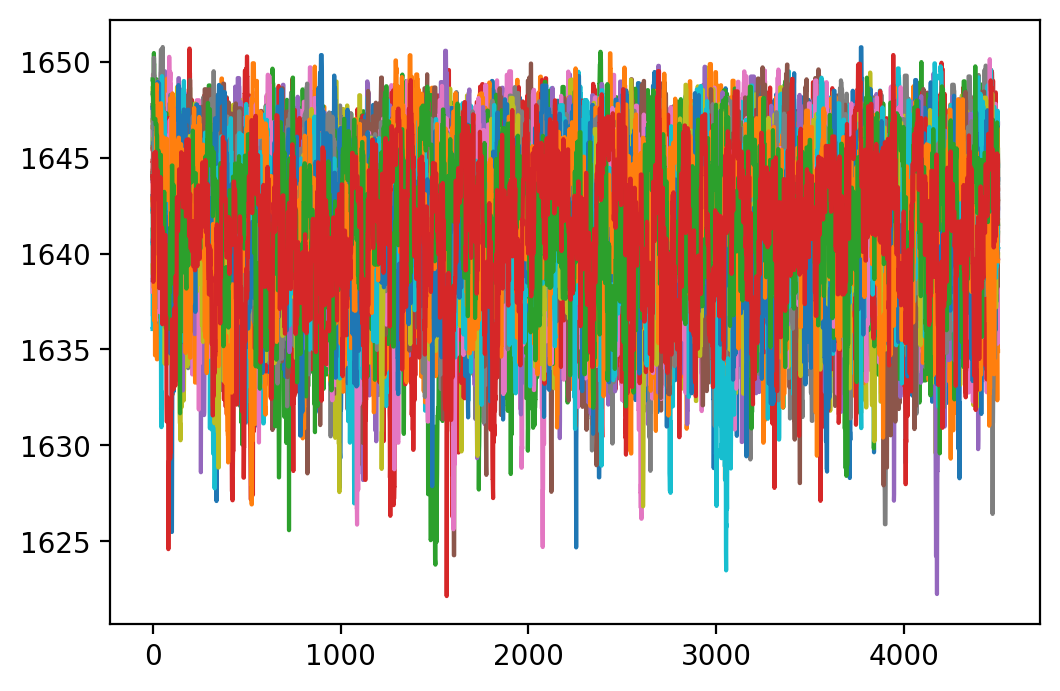

In [16]:
nb = 0
min_lnp = -np.inf

good_walkers = np.where(np.min(lnp[nb:], axis=0) > min_lnp)[0]

fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot(lnp[nb:, good_walkers]);

In [17]:
chain = sampler.get_chain(discard=nb)[:, good_walkers, :]

In [18]:
chain.shape

(4500, 34, 23)

In [26]:
nt = int(np.round(np.max(emcee.autocorr.integrated_time(chain))))

In [27]:
flat_chain = chain[::nt, :, :].reshape(-1, nd)

In [28]:
from corner import corner

In [29]:
nrpar = model.azr.config.n1

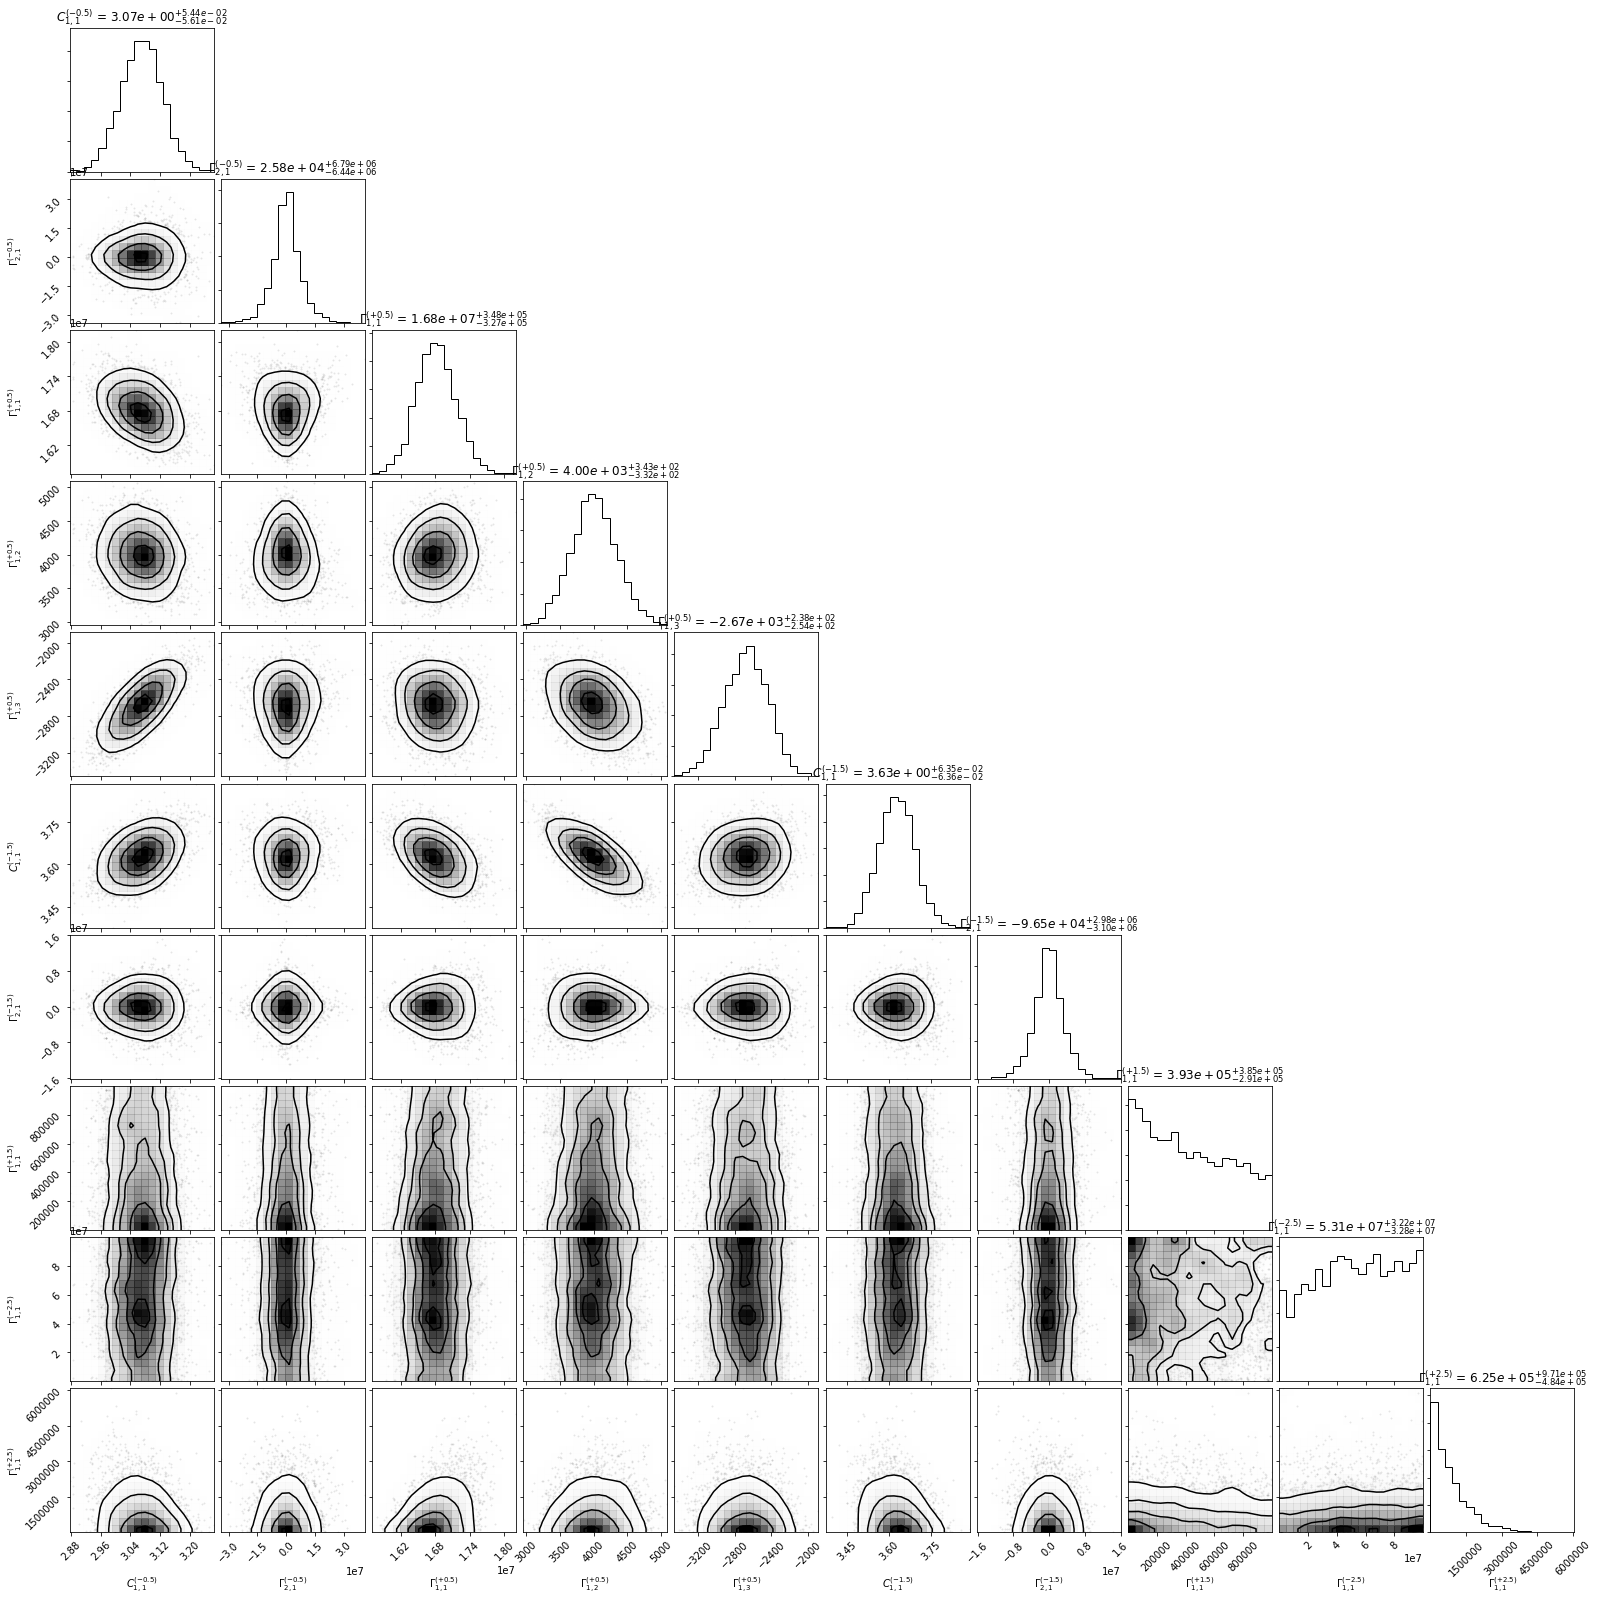

In [31]:
fig = corner(flat_chain[:, :nrpar], show_titles=True, smooth=True, labels=model.azr.config.labels[:nrpar],
             title_fmt='.2e')

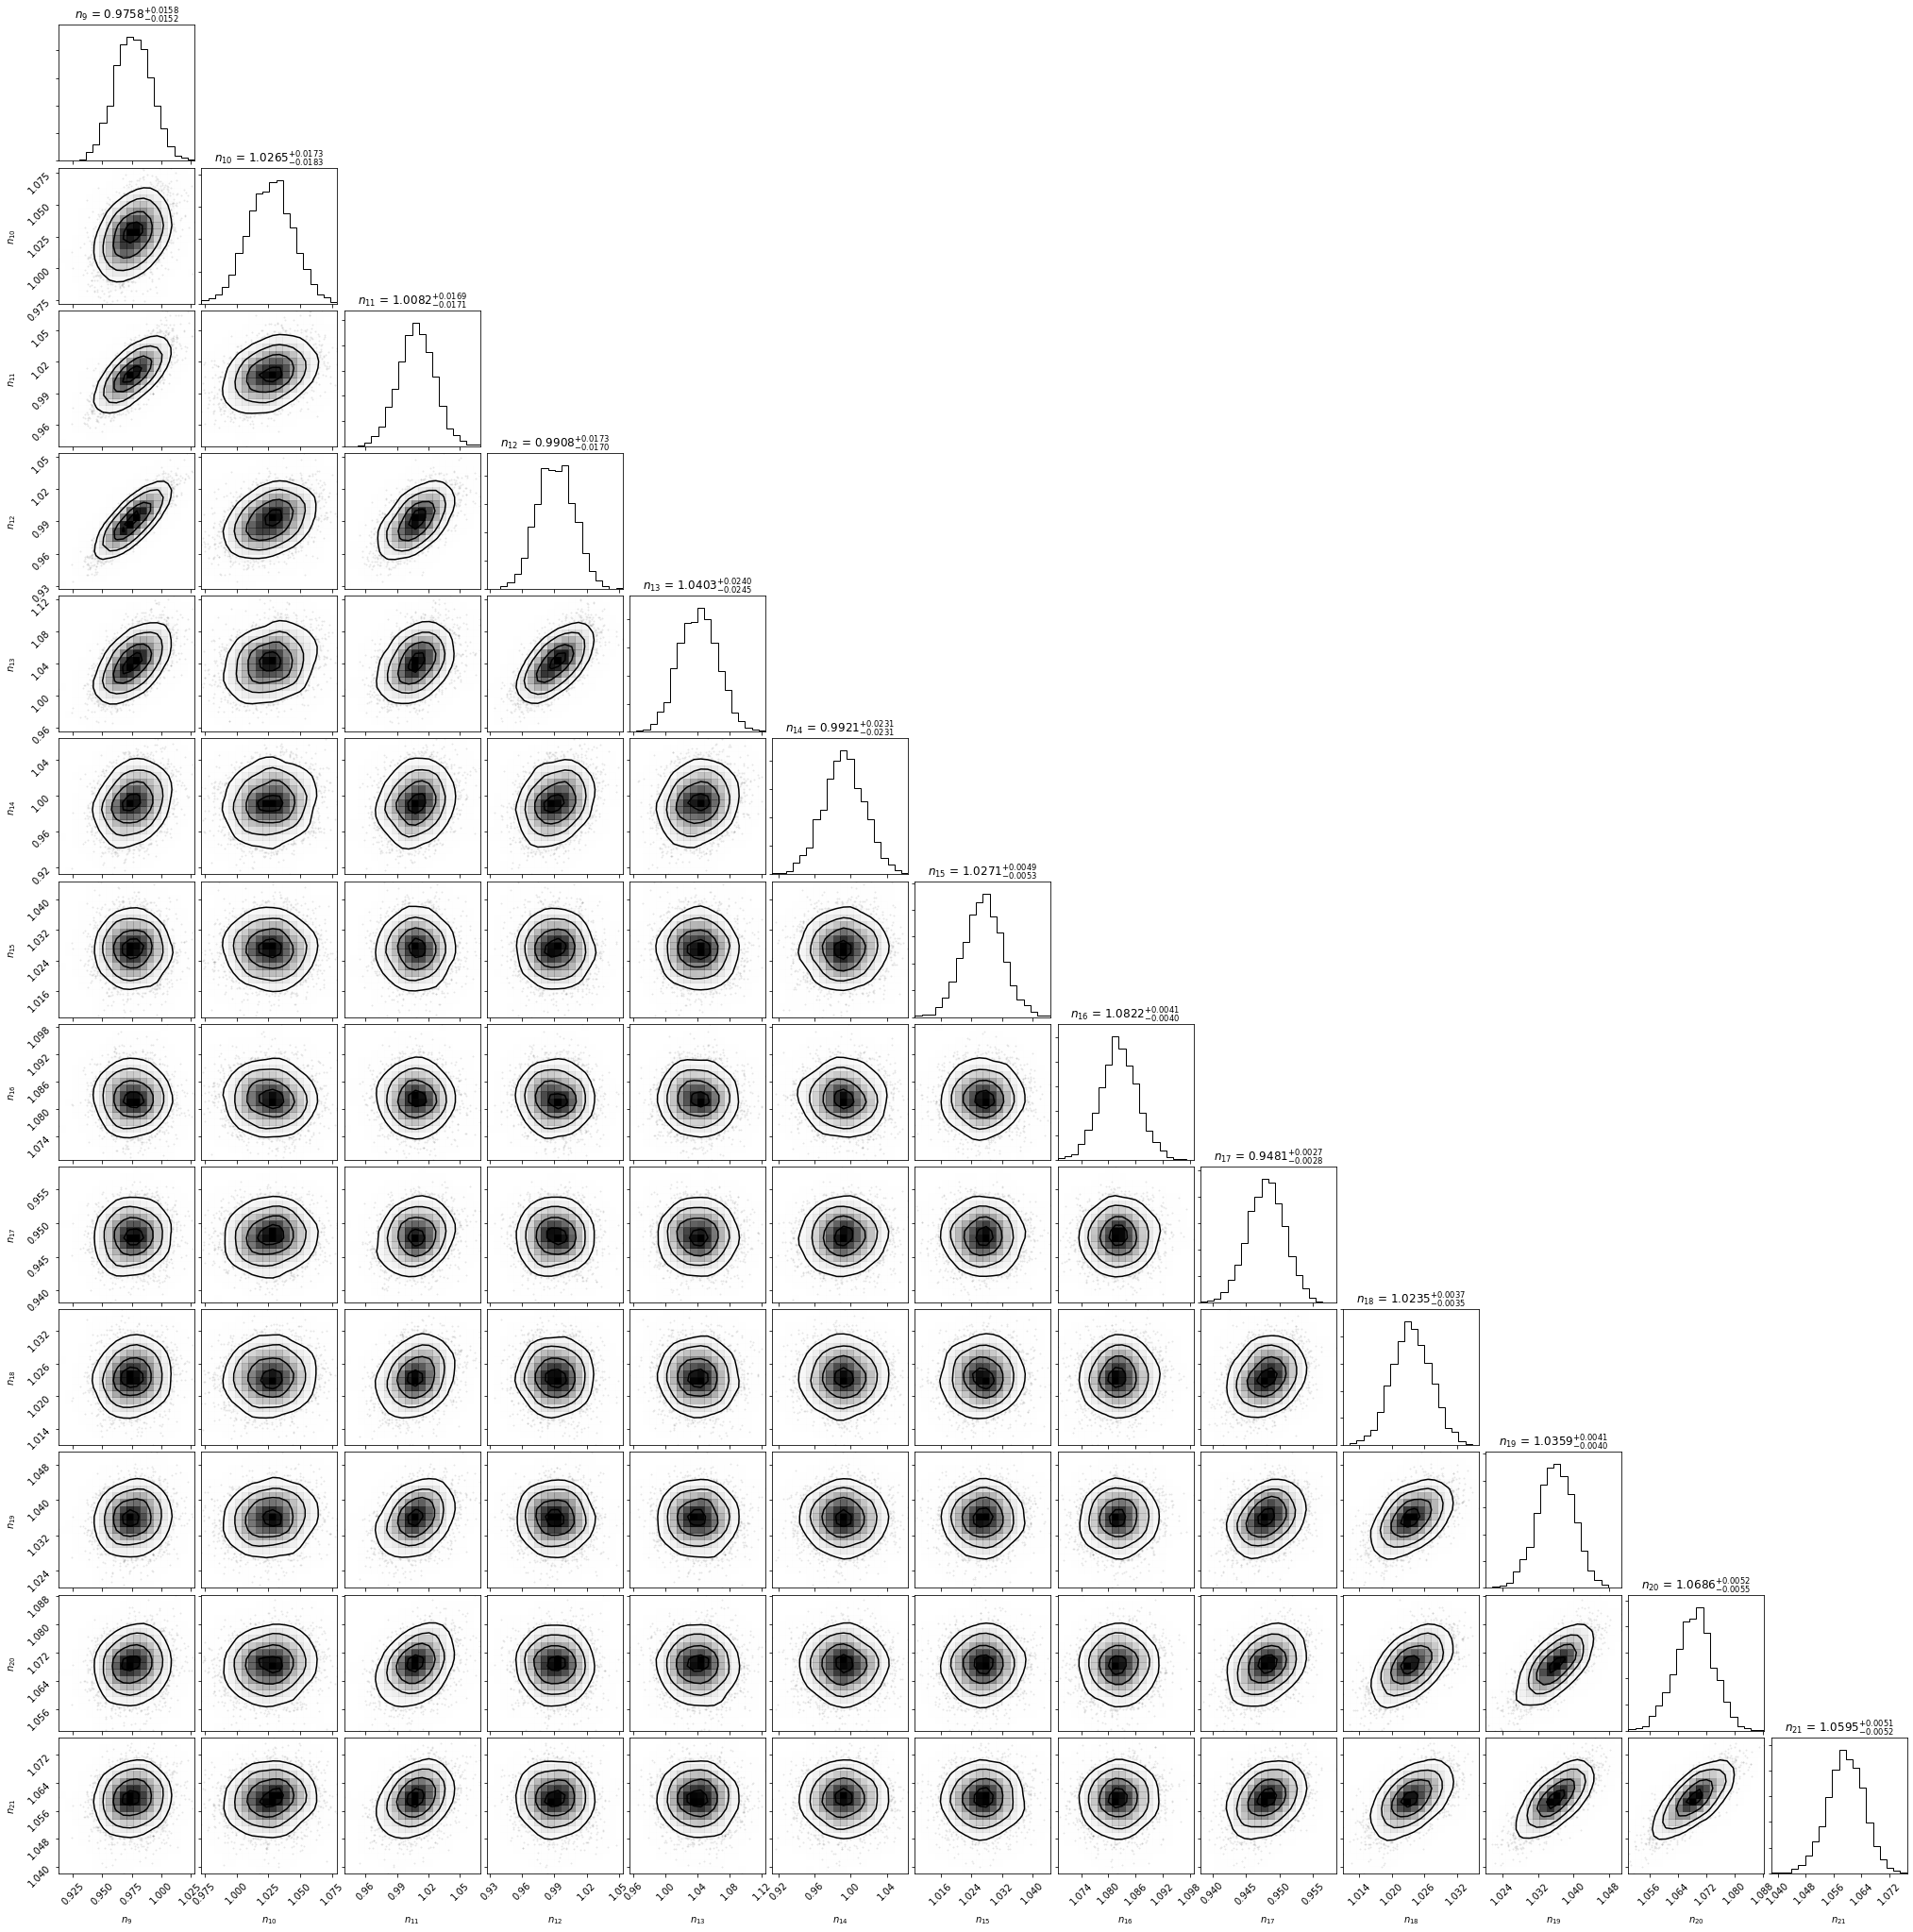

In [32]:
fig = corner(flat_chain[:, nrpar:], show_titles=True, smooth=True, labels=model.azr.config.labels[nrpar:],
             title_fmt='.4f')

In [34]:
# np.save('model_1.npy', flat_chain)

In [8]:
# files = ['AZUREOut_aa=1_R=1.out',
#          'AZUREOut_aa=1_R=2.out',
#          'AZUREOut_aa=1_TOTAL_CAPTURE.out']
# data = np.vstack([np.loadtxt('output/' + f) for f in files])
# np.savetxt('bare_uncertainties.txt', data[:, 6])

In [36]:
ii = np.argmax(lnp.flatten())

In [37]:
ii

19404

In [41]:
theta_star = np.savetxt('theta_star.txt', sampler.get_chain(flat=True)[ii])